# One Class Support Vector Machines

## Importing Libraries

In [1]:
# Data Processing
import numpy as np
import pandas as pd
from collections import Counter

# Importing tde
import tde

import matplotlib.pyplot as plt

# Model and Performance
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report #for model performance evaluation

# To generate the for loops
import glob
import os
from matplotlib import ticker

## Data Management

In [2]:
# READ INFECTION TIME DATA
infection_data = pd.read_excel('/Users/yoddmena/Downloads/Research/Telemetry_edited/MRSA - Master sheet.xlsx', index_col=0)

# READ AND EXTRACT DATA FROM FOLDER CONTAINING EXCEL SHEETS
folder = "/Users/yoddmena/Downloads/Research/Telemetry_edited/"
files = glob.glob( folder + "Ex *.xlsx" ) 

In [3]:
# CREATE A LIST OF TEMPERATURES
temp = []

for file in files:
    df = pd.read_excel(file)
    file_temp = df.iloc[:, 3::2]  # slicing the data for only temperature
    
    # Ensure that the number of minutes matches the number of temperature columns
    num_temp_columns = file_temp.shape[1]
    
    # Iterate over every other column in file_temp
    for j in range(0, num_temp_columns):
        # Extract the specific temperature column and its corresponding minutes
        column_name = file_temp.columns[j]
        temperature = file_temp[column_name]
        
        # Append the temperature and minutes to each lists
        temp.append(temperature)

## Creating Data Frames

In [4]:
##### INFECTION DATA
infection_data = infection_data.iloc[:,[1,9]]
infection_data = infection_data.T # transpose the data

infection_data.columns = infection_data.iloc[0] # Assign the values of the first row as the new column names

infection_data = infection_data[1:] # Remove the first row (previous column names)


##### TEMPERATURE DATA
df_temp = pd.DataFrame(temp)
df_temp = df_temp.T # transpose the data

df_temp.columns = df_temp.columns.astype(str).str.split(' ').str[0] # Rename columns keeping only the first word


## Scores

In [5]:
# IMPORTING THE SVM MODEL
# this model is from SckiKit Learn
model = svm.OneClassSVM()

# SIGMOID DEFINITION
# we will use the sigmoid function to make our scores be a numerical value that lies between 0 and 1

beta = (2/700) # 700 is the largest value
def sigmoid(scores, beta):
    return 1 / (1 + np.exp(-beta * scores))

In [105]:
#fig,ax = plt.subplots(2,1,figsize=(15,10), sharex = False)
#fig.set_facecolor("white")

train_end = 4320
shift = 2*360 # since the period is 6 hours (360) and we do this twice

# LISTS
# First anomalies after infection
min_scores = []
first_anom_train = []
first_anom_inf = []
score_train = []
score_infec = []
tpr = []

for i in range(0, df_temp.shape[1]): #df_temp.shape[1]
    #ax[0].cla()  # clear axis 0-1
    #ax[1].cla()
    
    #mice_min = range(0, df_temp.shape[0]) # Get the specific minutes for the current temperature time series
    
    temp_value = df_temp.iloc[:, i] # extract the temperature values for the current column
    mice_temp = df_temp.iloc[:, i].to_frame() # converting temp list to data frame
    
    names = mice_temp.columns[0] # get the column name for the current file
    
    # Filing in missing data
    temp_value_fw = temp_value.fillna(method='ffill') # foward fill
    temp_value_bw = temp_value_fw.fillna(method='bfill') # backward fill after forward fill
    
    # Time Delay Embedding
    temp_tde = tde.tde(temp_value_bw) # using the tde file
    temp_tde = temp_tde.T # transporting the data
    
    ##################################################################
    # Fit the Data on the first 3 days (3*24*60) 
    model.fit(temp_tde[:train_end+1,:])
    
    # Predict the Data
    predict_train_data = model.predict(temp_tde[:train_end+1,:]) # predict on training data
    predict_test_data = model.predict(temp_tde[train_end+1:,:]) # predicting on test data
    
    # Scores
    scores_train_data = model.score_samples(temp_tde[:train_end+1,:]) # scores on training data 
    scores_test_data = model.score_samples(temp_tde[train_end+1:,:]) # scores on test data
    
    threshold = model.offset_
    
    ##################################################################
    # Combine training and testing scores and predictions
    combined_scores= np.concatenate((scores_train_data, scores_test_data), axis=0)
    combined_predictions = np.concatenate((predict_train_data, predict_test_data), axis=0)
    
    time = np.arange(temp_tde.shape[0])+(shift) # 2 times the time delay shift
    
    # Minimum score
    min_score = scores_train_data.min()
    
    # Find the indices of the anomalies
    anomaly_indices = np.where(combined_scores <= min_score)[0] #finding the values where its -1 (anomaly)
    time_2 = anomaly_indices + (shift) # shifting the time for plotting
    '''
    ##################################################################
    # Plotting 1st Graph
    ax[0].plot(time, combined_scores, '-', color='#6693F5', alpha=0.75)  # Plot the scores with blue color #[:100]
    ax[0].grid()
    ax[0].set_ylabel("Score", fontsize=14)
    ax[0].set_title(f"Anomalies found using SckiKit Learn's threshold for '{names}'", fontsize=14)
    ax[0].set_xlim(-10,26000)
    ax[0].set_ylim(0,700)
    ax[0].axhline(y = threshold, color='red', linestyle='-', label='threshold')
    # Plot the anomalies with red color
    #ax[0].plot(time_2, combined_scores[anomaly_indices], '', color='purple') #[:100]
    #ax[0].axhline(y=min_score, color='red', linestyle='-')
    '''
    ##################################################################
    # Plotting infection time
    matching_columns = set(mice_temp.columns).intersection(infection_data.columns)
    
    if matching_columns:
        column_name = matching_columns.pop()
        infection_time = infection_data.loc['Aprprox Infection Minute', column_name]
        # Add a vertical line at the infection time
        #ax[1].axvline(x = infection_time, color='purple', linestyle='-', label='Infection time')
        print(f"Found '{column_name}' and its infection value is '{infection_time}'")
    else:
        print(f"No match found for mouse '{names}'")
    
    ##################################################################
    # Find the index at which the first score is less than min_score
    boolean = combined_scores < min_score
    anom_train = np.argmax(boolean) #+shift
    anom_infec = np.argmax(boolean[infection_time-shift:]) + infection_time 
    
    # Get the corresponding value
    value = combined_scores[anom_train]
    value_1 = combined_scores[anom_infec-shift]
    
    # Calculating the time first anomaly was found after training and infection
    time_aft_train = (anom_train + shift) - train_end
    time_aft_infection = anom_infec - infection_time
    
    # Calculating the amount of false negatives (between end of train and infection time)
    count_false_neg = np.count_nonzero(boolean[train_end:infection_time])
    
    # Calculating the amount of true positives (infection time)
    count_true_pos = np.count_nonzero(boolean[infection_time:]) 
    
    # Calculating true positive rate
    # Check if the denominator is zero
    if (count_true_pos + count_false_neg) == 0:
        print("Skipping division ")
        continue  # Skip this iteration and move to the next number
    TPR = count_true_pos / (count_true_pos + count_false_neg)
    '''
    ##################################################################
    # Plotting 2nd Graph
    ax[1].plot(time, combined_scores, '-', color='#6693F5', alpha=0.75)  # Plot the scores with blue color #[:100]
    ax[1].plot(time_2, combined_scores[anomaly_indices], '', color='purple') #coloring anomalies
    ax[1].grid()
    ax[1].set_ylabel("Score", fontsize=14)
    ax[1].set_xlabel("Minutes", fontsize=14)
    ax[1].set_title(f"Anomalies found using our threshold for '{names}'", fontsize=14)
    #ax[1].set_xlim(infection_time-5,infection_time+30)
    ax[1].set_xlim(-10,26000)
    ax[1].set_ylim(0,700)
    
    ##################################################################
    # Plotting Horizontal and Vertical Lines
    ax[1].axvline(x = anom_train+shift, color='blue', linestyle='--', label='First anomaly after training') # when the first value is less the minimum value
    ax[1].axvline(x = train_end, color='green', linestyle='-', label='End of training data')
    ax[1].axhline(y=min_score, color='red', linestyle='-', label='Threshold')
    ax[1].axvline(x = anom_infec, color='orange', linestyle ='-', label='First anomaly after infection')
    #ax[1].axhline(y=value, color='blue', linestyle='--', label='value')
    #ax[1].axhline(y=value_1, color='orange', linestyle='-', label='value_1')
    ax[1].legend()
    '''
    ##################################################################
    # Print Values
    print("Minimum Score: ", min_score)
    print("After Training Min: ", anom_train+shift)
    print("After Infection Min: ", anom_infec)
    print(f"First anomaly found after training: {time_aft_train} minutes with score {value}")
    print(f"First anomaly found after infection: {time_aft_infection} minutes with score {value_1}")
    print(f"True Positve Rate: {TPR*100}%")
    
    ##################################################################
    # Appending to Lists
    min_scores.append(min_score)
    first_anom_train.append(time_aft_train)
    first_anom_inf.append(time_aft_infection)
    score_train.append(value)
    score_infec.append(value_1)
    tpr.append(TPR)
   

Found 'CC006-315' and its infection value is '10300'
Minimum Score:  267.52007264767286
After Training Min:  11043
After Infection Min:  11043
First anomaly found after training: 6723 minutes with score 267.4976407369712
First anomaly found after infection: 743 minutes with score 267.4976407369712
True Positve Rate: 100.0%
Found 'CC006-316' and its infection value is '10300'
Minimum Score:  274.82851288077353
After Training Min:  6949
After Infection Min:  10462
First anomaly found after training: 2629 minutes with score 271.684894294429
First anomaly found after infection: 162 minutes with score 268.1715669032109
True Positve Rate: 98.08883112911857%
Found 'CC006-317' and its infection value is '10300'
Minimum Score:  293.83288135042164
After Training Min:  6702
After Infection Min:  12666
First anomaly found after training: 2382 minutes with score 271.149233897299
First anomaly found after infection: 2366 minutes with score 263.58820191686965
True Positve Rate: 99.80148455031936%
Fou

Found 'CC001-364' and its infection value is '10250'
Minimum Score:  217.33935950764163
After Training Min:  5921
After Infection Min:  10251
First anomaly found after training: 1601 minutes with score 216.81097093242886
First anomaly found after infection: 1 minutes with score 204.98942870336646
True Positve Rate: 3.3333333333333335%
Found 'CC001-366' and its infection value is '10250'
Minimum Score:  228.22563959151606
After Training Min:  5267
After Infection Min:  12382
First anomaly found after training: 947 minutes with score 210.6300858538827
First anomaly found after infection: 2132 minutes with score 214.56811397150102
True Positve Rate: 51.183431952662716%
Found 'CC003-225' and its infection value is '10250'
Minimum Score:  232.67180713933914
After Training Min:  10997
After Infection Min:  10997
First anomaly found after training: 6677 minutes with score 203.1991567801985
First anomaly found after infection: 747 minutes with score 203.1991567801985
True Positve Rate: 100.0%


Found 'CC061-554' and its infection value is '10500'
Minimum Score:  270.1155743014992
After Training Min:  5058
After Infection Min:  10519
First anomaly found after training: 738 minutes with score 269.8129545391105
First anomaly found after infection: 19 minutes with score 237.00638964081503
True Positve Rate: 17.894736842105264%
Found 'CC061-555' and its infection value is '10500'
Minimum Score:  254.32371350378915
After Training Min:  6963
After Infection Min:  10518
First anomaly found after training: 2643 minutes with score 252.21014655491933
First anomaly found after infection: 18 minutes with score 241.5342331838244
True Positve Rate: 4.358353510895883%
Found 'CC061-556' and its infection value is '10500'
Minimum Score:  250.67817127460677
After Training Min:  5440
After Infection Min:  10520
First anomaly found after training: 1120 minutes with score 245.17969738695575
First anomaly found after infection: 20 minutes with score 200.75366388933185
True Positve Rate: 99.44762089

Found 'CC053-427' and its infection value is '11500'
Minimum Score:  210.56980102256637
After Training Min:  5446
After Infection Min:  11868
First anomaly found after training: 1126 minutes with score 195.83775427051341
First anomaly found after infection: 368 minutes with score 202.10065806361763
True Positve Rate: 97.13406424312367%
Found 'CC053-428' and its infection value is '11500'
Minimum Score:  250.15654007967382
After Training Min:  5304
After Infection Min:  11500
First anomaly found after training: 984 minutes with score 229.81109105751773
First anomaly found after infection: 0 minutes with score 148.46087898657242
True Positve Rate: 57.474069554606466%
Found 'CC057-730' and its infection value is '11500'
Minimum Score:  245.03481439094543
After Training Min:  8507
After Infection Min:  11743
First anomaly found after training: 4187 minutes with score 237.27755846227703
First anomaly found after infection: 243 minutes with score 242.1530816226212
True Positve Rate: 17.97752

Found 'CC003-187' and its infection value is '10250'
Minimum Score:  180.5017605128329
After Training Min:  10264
After Infection Min:  10264
First anomaly found after training: 5944 minutes with score 176.06464887067972
First anomaly found after infection: 14 minutes with score 176.06464887067972
True Positve Rate: 32.35294117647059%
Found 'CC003-190' and its infection value is '10250'
Minimum Score:  259.5958794337632
After Training Min:  5075
After Infection Min:  10265
First anomaly found after training: 755 minutes with score 258.01315884510444
First anomaly found after infection: 15 minutes with score 222.06984455013605
True Positve Rate: 73.28990228013029%
Found 'CC012-1348' and its infection value is '10250'
Minimum Score:  307.58919343028316
After Training Min:  5329
After Infection Min:  10276
First anomaly found after training: 1009 minutes with score 298.5871160848183
First anomaly found after infection: 26 minutes with score 299.87394784742656
True Positve Rate: 95.6801470

Found 'CC027-393' and its infection value is '10000'
Minimum Score:  248.8681512967733
After Training Min:  5688
After Infection Min:  11357
First anomaly found after training: 1368 minutes with score 239.8035017784798
First anomaly found after infection: 1357 minutes with score 226.4436164261224
True Positve Rate: 99.55685618729096%
Found 'CC042-330' and its infection value is '10000'
Minimum Score:  297.94845836240853
After Training Min:  7152
After Infection Min:  10164
First anomaly found after training: 2832 minutes with score 58.0374295961829
First anomaly found after infection: 164 minutes with score 290.51699818683255
True Positve Rate: 93.67541766109785%
Found 'CC042-331' and its infection value is '10000'
Minimum Score:  202.72191759825478
After Training Min:  7151
After Infection Min:  10102
First anomaly found after training: 2831 minutes with score 178.24963050438942
First anomaly found after infection: 102 minutes with score 202.68606470069358
True Positve Rate: 79.448621

Found 'CC057-704' and its infection value is '10100'
Skipping division 
Found 'CC057-705' and its infection value is '10100'
Minimum Score:  198.22003088656584
After Training Min:  5904
After Infection Min:  14116
First anomaly found after training: 1584 minutes with score 190.20591668942234
First anomaly found after infection: 4016 minutes with score 196.01653824260427
True Positve Rate: 77.59562841530054%
Found 'C57Bl6-108' and its infection value is '10200'
Minimum Score:  372.0099282449168
After Training Min:  6399
After Infection Min:  10214
First anomaly found after training: 2079 minutes with score 367.2541051889011
First anomaly found after infection: 14 minutes with score 358.8230384933783
True Positve Rate: 91.91666666666667%
Found 'CC017-394' and its infection value is '10200'
Minimum Score:  259.49653582071267
After Training Min:  7064
After Infection Min:  14233
First anomaly found after training: 2744 minutes with score 256.8986427646997
First anomaly found after infectio

In [106]:
# Make all lists into arrays
ms = np.array(min_scores)
fat = np.array(first_anom_train)
fai = np.array(first_anom_inf)
st = np.array(score_train)
si = np.array(score_infec)
tprs = np.array(tpr)

In [119]:
# Create the data for the table (calculates statistics)
data = {
    'column_1': [round(np.mean(ms),2), round(np.mean(fat),2), round(np.mean(fai),2), round(np.mean(st),2), round(np.mean(si),2), round(np.mean(tprs)*100,2)],
    'column_2': [round(np.std(ms),2), round(np.std(fat),2), round(np.std(fai),2), round(np.std(st),2), round(np.std(si),2), round(np.std(tprs)*100,2)],
    'column_3': [round(np.percentile(ms, 25),2), round(np.percentile(fat, 25),2), round(np.percentile(fai, 25),2), round(np.percentile(st, 25),2), round(np.percentile(si, 25),2), round(np.percentile(tprs, 25)*100,2)],
    'column_4': [round(np.percentile(ms, 50),2), round(np.percentile(fat, 50),2), round(np.percentile(fai, 50),2), round(np.percentile(st, 50),2), round(np.percentile(si, 50),2), round(np.percentile(tprs, 50)*100,2)],
    'column_5': [round(np.percentile(ms, 75),2), round(np.percentile(fat, 75),2), round(np.percentile(fai, 75),2), round(np.percentile(st, 75),2), round(np.percentile(si, 75),2), round(np.percentile(tprs, 75)*100,2)]
}

In [120]:
# Create a DataFrame
df = pd.DataFrame(data)

# Set row names (index)
row_names = ['Minimum Score', 'First Anomaly Time After Training', 'First Anomaly Time After Infection', 'First Anomaly Score After Training', 'First Anomaly Score After Infection  ', 'True Positive Rate']
df.index = row_names

# Set column names
column_names = ['Mean', 'Standard Deviation', 'Quartile 1 (25%)', 'Quartile 2 (Med)', 'Quartile 3 (75%)']
df.columns = column_names

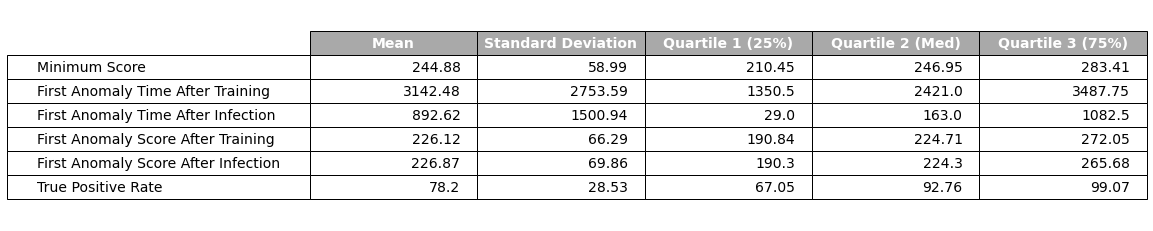

In [122]:
# Saving the Table
# Create a table visualization using matplotlib
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(2.5, 2)  # Adjust the scaling factor as per your requirements

# Modify the column names as dark color boxes
for i, col_name in enumerate(df.columns):
    cell = table[0, i]
    cell.set_text_props(weight='bold', color='white')
    cell.set_facecolor('darkgray')
    
# Save the table as an image file
plt.savefig('table_statistics_3days.png', bbox_inches='tight', facecolor='white')
